# Transformers-based Classification (Multi Label)

This notebook implements transformer-based models to classify research papers into categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from ast import literal_eval
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy

## Data Loading & Preprocessing


In [2]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_multi_label_2025.csv")
df_existing.head(2)

,title,abstract,link,authors,category
0,A Framework to Generate Neurosymbolic PDDL-com...,Symbolic task planning is a widely used approa...,https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",['plan-generation']
1,A Prefrontal Cortex-inspired Architecture for ...,Large language models (LLMs) demonstrate impre...,https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",['brain-inspired-planning']


In [3]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/new_arxiv_papers_20251025_120307.csv")
df_new.head(2)

,Title,Authors,Published Date,Abstract,URL,Categories
0,Using Large Language Models for Abstraction of...,"Bita Banihashemi, Megh Patel, Yves Lespérance",2025-10-23,Generating an abstraction of a dynamic domain ...,http://arxiv.org/abs/2510.20258v1,"cs.AI, I.2"
1,A Systematic Study of Large Language Models fo...,Jorge Mendez-Mendez,2025-09-30,Using large language models (LLMs) to solve co...,http://arxiv.org/abs/2510.00182v1,"cs.RO, cs.AI"


In [4]:
# Function to standardize category format
def standardize_categories(categories):
    if isinstance(categories, str):
        # Handle string representation of lists
        if categories.startswith("["):
            categories = literal_eval(categories)
        # Handle single string
        elif categories == "-":
            return []
        else:
            # Split by comma and clean up
            categories = [cat.strip() for cat in categories.split(",")]

    # Standardize category names
    standardized = []
    if isinstance(categories, list):
        for cat in categories:
            # Convert to lowercase and replace spaces with hyphens
            cat = cat.lower().replace(" ", "-")
            # Remove any special characters if needed
            standardized.append(cat)

    return standardized

In [5]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [6]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_existing = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [7]:
X_existing_array = X_existing.toarray()

In [8]:
df_existing["category"] = df_existing["category"].apply(standardize_categories)

In [9]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

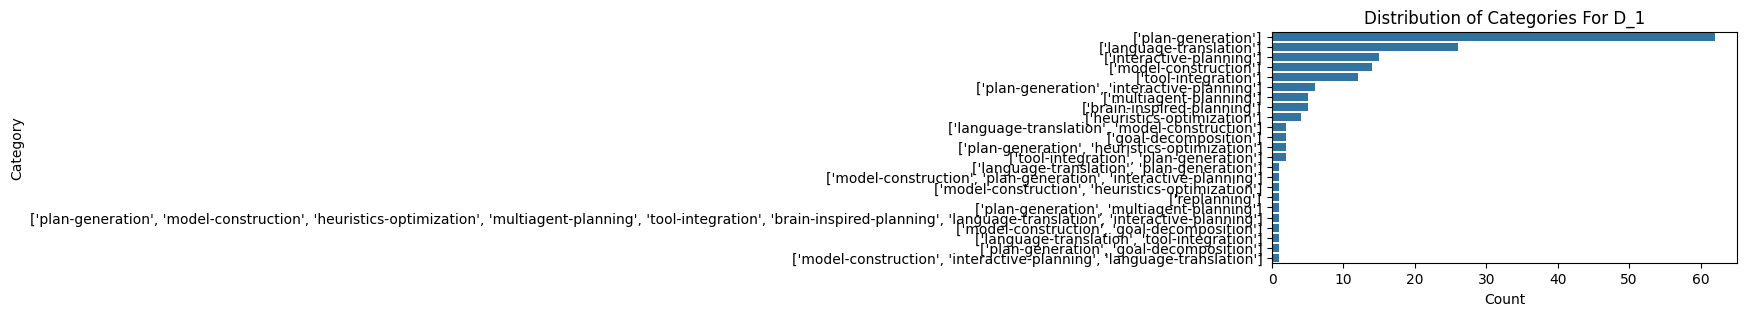

In [10]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_1")

<br>


## Create Features


In [11]:
# Fit MLB only on training categories
mlb = MultiLabelBinarizer()
y_old = mlb.fit_transform(df_existing["category"])

In [12]:
# Split old data into train and test sets
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

train_idx, test_idx = next(msss.split(X_existing_array, y_old))

X_train = X_existing[train_idx]
X_test = X_existing[test_idx]

df_train = df_existing.iloc[train_idx].copy()
df_test = df_existing.iloc[test_idx].copy()

y_train = y_old[train_idx]
y_test = y_old[test_idx]

In [13]:
print(f"Training set shape: {df_train.shape}, TF-IDF matrix: {X_train.shape}")
print(f"Test set shape: {df_test.shape}, TF-IDF matrix: {X_test.shape}")

Training set shape: (131, 6), TF-IDF matrix: (131, 3392)
Test set shape: (36, 6), TF-IDF matrix: (36, 3392)


In [14]:
def print_label_distribution(y, set_name):
    label_counts = y.sum(axis=0)
    print(f"\nLabel distribution in {set_name}:")
    for idx, count in enumerate(label_counts):
        if count > 0:
            print(f"{mlb.classes_[idx]}: {int(count)}")

print_label_distribution(y_train, "training set")
print_label_distribution(y_test, "test set")


Label distribution in training set:
brain-inspired-planning: 5
goal-decomposition: 3
heuristics-optimization: 6
interactive-planning: 19
language-translation: 25
model-construction: 17
multiagent-planning: 6
plan-generation: 61
replanning: 1
tool-integration: 13

Label distribution in test set:
brain-inspired-planning: 1
goal-decomposition: 1
heuristics-optimization: 2
interactive-planning: 5
language-translation: 7
model-construction: 4
multiagent-planning: 1
plan-generation: 16
tool-integration: 3


## Train, Evaluate, and Test Model


In [15]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is a false-y value or not supplied, disables deterministic mode."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed = 13
set_seed(seed)

In [16]:
class PaperDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

In [19]:
class TransformerClassifier:
    def __init__(
        self,
        model_name,
        num_labels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.base_model = AutoModel.from_pretrained(model_name).to(device)

        # Freeze the transformer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Classifier for multi-label classification
        self.classifier = torch.nn.Linear(
            self.base_model.config.hidden_size, num_labels
        ).to(device)

    def get_embeddings(self, texts, batch_size=8):
        if isinstance(texts, pd.Series):
            texts = texts.tolist()

        dataset = PaperDataset(texts, self.tokenizer)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []

        self.base_model.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Getting embeddings"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)

                outputs = self.base_model(
                    input_ids=input_ids, attention_mask=attention_mask
                )
                embeddings = outputs.last_hidden_state[:, 0, :]
                all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

    def fit(
        self, train_texts, train_labels, epochs=3, batch_size=8, learning_rate=1e-3
    ):
        train_embeddings = self.get_embeddings(train_texts, batch_size=batch_size)
        train_labels = torch.tensor(train_labels).float()

        train_dataset = torch.utils.data.TensorDataset(train_embeddings, train_labels)
        train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=learning_rate)
        loss_fn = torch.nn.BCEWithLogitsLoss()

        self.classifier.train()
        for epoch in range(epochs):
            for embeddings, labels in tqdm(
                train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
            ):
                embeddings, labels = embeddings.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                logits = self.classifier(embeddings)
                loss = loss_fn(logits, labels)
                loss.backward()
                optimizer.step()

    def predict(self, texts, batch_size=8, threshold=0.5):
        embeddings = self.get_embeddings(texts, batch_size=batch_size)
        self.classifier.eval()
        with torch.no_grad():
            logits = self.classifier(embeddings.to(self.device))
            predictions = torch.sigmoid(logits) > threshold
        return predictions.cpu().numpy()

In [20]:
def evaluate_models(df_train, y_train, df_test, y_test, df_new, mlb):
    model_configs = {
        "BERT": "bert-base-uncased",
        "SciBERT": "allenai/scibert_scivocab_uncased",
    }

    results = {}

    for model_name, model_path in model_configs.items():
        print(f"\nEvaluating {model_name}...")

        classifier = TransformerClassifier(model_path, num_labels=len(mlb.classes_))
        classifier.fit(df_train["text"], y_train)

        y_pred_test = classifier.predict(df_test["text"])
        y_pred_new = classifier.predict(df_new["text"])

        predictions_labels = mlb.inverse_transform(y_pred_new)

        results[model_name] = {
            "test_report": classification_report(
                y_test, y_pred_test, target_names=mlb.classes_, zero_division=0
            ),
            "predictions_binary": y_pred_new,
            "predictions_labels": predictions_labels,
        }

        df_new[f"{model_name}_predicted"] = predictions_labels

    return results

In [21]:
# Now evaluate the models using the test set we created earlier
results = evaluate_models(df_train, y_train, df_test, y_test, df_new, mlb)


Evaluating BERT...


/Users/nitingupta/miniconda3/envs/aiisc_litcat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it]




Evaluating SciBERT...


/Users/nitingupta/miniconda3/envs/aiisc_litcat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████| 7/7 [00:25<00:00,  3.70s/it]



In [22]:
# Print results for the test dataset
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(model_data["test_report"])


Results for BERT on test set:
                         precision    recall  f1-score   support

brain-inspired-planning       0.00      0.00      0.00         1
     goal-decomposition       0.00      0.00      0.00         1
heuristics-optimization       0.00      0.00      0.00         2
   interactive-planning       0.00      0.00      0.00         5
   language-translation       0.00      0.00      0.00         7
     model-construction       0.00      0.00      0.00         4
    multiagent-planning       0.00      0.00      0.00         1
        plan-generation       0.60      0.19      0.29        16
             replanning       0.00      0.00      0.00         0
       tool-integration       0.00      0.00      0.00         3

              micro avg       0.60      0.07      0.13        40
              macro avg       0.06      0.02      0.03        40
           weighted avg       0.24      0.07      0.11        40
            samples avg       0.08      0.08      0.08   

In [23]:
# Convert predictions back to categories for all classifiers
for classifier, data in results.items():
    df_new[f"{classifier}_predicted"] = data["predictions_labels"]
    print(f"\nPredicted category distribution for {classifier}:")
    predicted_series = pd.Series(data["predictions_labels"]).explode().dropna()
    print(predicted_series.value_counts())


Predicted category distribution for BERT:
plan-generation    9
Name: count, dtype: int64

Predicted category distribution for SciBERT:
plan-generation    28
Name: count, dtype: int64


In [24]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'text', 'BERT_predicted', 'SciBERT_predicted'],
      dtype='object')

In [25]:
# Save results to a new CSV for predictions
df_new.to_csv("../outputs/tf_multi_label_preds_2025.csv", index=False)